# Figure 1.
The ``ACCACIA'' PMC as represented in (a) AVHRR channel 4 cloud cover (1220UTC), (b, e) ASCAT retrievals (c, f) ERA5 and (d, g) ERA-Interim on 26 March 2013: (b, c, d) relative vorticity (shading, $10^{-4}$ $s^{-1}$) and SLP (red contours, every $2$ $hPa$), (e, f, g) horizontal wind speed (shading, $m$ $s^{-1}$). The ASCAT data are shown at $10$ $m$ above sea level at 1300UTC, while the reanalysis data are at  $950$ $hPa$ level at 1200UTC.

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

Import the necessary libraries.

In [1]:
from datetime import datetime
import string

from arke.cart import merc_map_grid, label_map
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Rectangle
import numpy as np
import xarray as xr
import xesmf as xe

from common_defs import winters, nyr, datasets, bbox, aliases
import mypaths
from obs_tracks_api import prepare_tracks, read_all_accacia
from plot_utils import LCC_KW, trans, iletters, div_cmap, use_style
from sat_utils import read_raster_stereo

In [2]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning, module="cartopy")

In [3]:
use_style()

In [4]:
zoom_box = [-10, 25, 68, 78]

## ACCACIA PL track

In [5]:
acc_tracks = prepare_tracks(read_all_accacia())

In [6]:
the_track = acc_tracks[10]

## Reanalysis data

In [7]:
accacia_pl_datetime = datetime(2013, 3, 26, 12)

In [8]:
dset_dict = dict()
for dataset in datasets:
    dset_dict[dataset] = xr.open_mfdataset(
        getattr(mypaths, f"{dataset}_dir").glob(f"*{accacia_pl_datetime:%Y.%m.}*.nc"),
        combine="by_coords",
    )

## Satellite data

### Load the data

In [9]:
ascat_ds = xr.open_dataset(mypaths.ascat_file)

In [10]:
ascat_ds = ascat_ds.assign_coords(lon=(((ascat_ds.lon + 180) % 360) - 180))

In [11]:
cond = (
    (ascat_ds.lon >= zoom_box[0])
    & (ascat_ds.lon <= zoom_box[1])
    & (ascat_ds.lat >= zoom_box[2])
    & (ascat_ds.lat <= zoom_box[3])
)

In [12]:
ascat_subset = ascat_ds.where(cond, drop=True)

In [13]:
ascat_dt = ascat_ds.time.values.astype("<M8[us]").astype(datetime)

### Calculate wind components and vorticity

In [14]:
from metpy.calc import vorticity, wind_components
from metpy.units import units
from metpy.xarray import preprocess_xarray

In [15]:
ascat_subset.wind_speed.attrs["units"] = "m s**-1"

In [16]:
u, v = preprocess_xarray(wind_components)(ascat_subset.wind_speed, ascat_subset.wind_dir)

vo = vorticity(u, v, dx=12.5e3, dy=12.5e3)

and convert vorticity to the `xarray.DataArray` type

In [17]:
u, v = -u, -v  # wind direction in ASCAT data is "rotated"

u = ascat_subset.wind_speed.copy(data=u.magnitude)
u = u.rename("eastward_wind")
u.attrs["long_name"] = "U component of wind"

v = ascat_subset.wind_speed.copy(data=v.magnitude)
v = v.rename("northward_wind")
v.attrs["long_name"] = "V component of wind"

In [18]:
vo = ascat_subset.wind_speed.copy(data=vo.magnitude)
vo = vo.rename("relative_vorticity")
vo.attrs["long_name"] = "Vorticity (relative)"
vo.attrs["units"] = "s**-1"

### Regrid to a regular lon-lat grid

define a grid onto which to interpolate the data

In [19]:
_dx = 0.1  # grid spacing
target_grid_ds = xe.util.grid_2d(
    zoom_box[0] - _dx / 2, zoom_box[1], _dx, zoom_box[2] - _dx / 2, zoom_box[3], _dx
)

In [20]:
regridder = xe.Regridder(ascat_subset, target_grid_ds, "bilinear", reuse_weights=False)

Overwrite existing file: bilinear_118x41_101x351.nc 
 You can set reuse_weights=True to save computing time.


In [21]:
_xr_dict = {}
for varname, ascat_var in (("u", u), ("v", v), ("vo", vo), ("wspd", ascat_subset.wind_speed)):
    _xr_dict[varname] = regridder(ascat_var)
    _xr_dict[varname].attrs.update(ascat_var.attrs)
ascat_ds_regr = xr.Dataset(_xr_dict).rename({"y": "latitude", "x": "longitude"})

ascat_ds_regr = ascat_ds_regr.assign_coords(
    longitude=ascat_ds_regr.lon.values[0, :], latitude=ascat_ds_regr.lat.values[:, 0]
).drop(["lon", "lat"])

### Load AVHRR data

In [22]:
avhrr_im, avhrr_extent, avhrr_crs = read_raster_stereo()

In [23]:
imshow_kw = dict(origin="upper", cmap="gray", interpolation="nearest")

In [24]:
AXGR_KW = dict(axes_pad=0.55, cbar_location="right", cbar_mode="edge", cbar_pad=0.2, cbar_size="3%")

In [25]:
MERC_KW = {k: v for k, v in LCC_KW.items() if not k in ["clon", "clat"]}
MERC_KW["ticks"] = [5, 1]
MERC_KW["extent"] = [-10, 25, 68, 78]
text_kw = dict(
    ha="center",
    va="center",
    fontsize="medium",
    path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")],
)

In [26]:
_toponyms = [
    dict(name="Svalbard", lon=15, lat=77.5),
    dict(name="Norway", lon=17, lat=69),
    dict(name="Fram\nStrait", lon=0, lat=77),
    dict(name="Norwegian\nSea", lon=5, lat=68.75),
]

In [27]:
wspd_kw = dict(
    add_colorbar=False, add_labels=False, levels=np.arange(6, 27, 3), cmap="Oranges", extend="max"
)
vo_kw = dict(
    levels=[-2, -0.2, 0.2, 2],
    cmap="PuOr_r",
    extend="both",
    add_colorbar=False,
    rasterized=True,
    add_labels=False,
)
vo_scale = 1e4
slp_kw = dict(
    add_colorbar=False, add_labels=False, colors="r", linewidths=0.5, levels=np.arange(800, 1100, 2)
)

line_kw = dict(
    color="C1",
    mec="C1",
    path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")],
    **trans
)

quiver_kw = dict(scale=100, scale_units="inches")
strides = {"era5": (2, 3), "interim": (1, 2), "ascat": (5, 8)}

NameError: name 'ax' is not defined

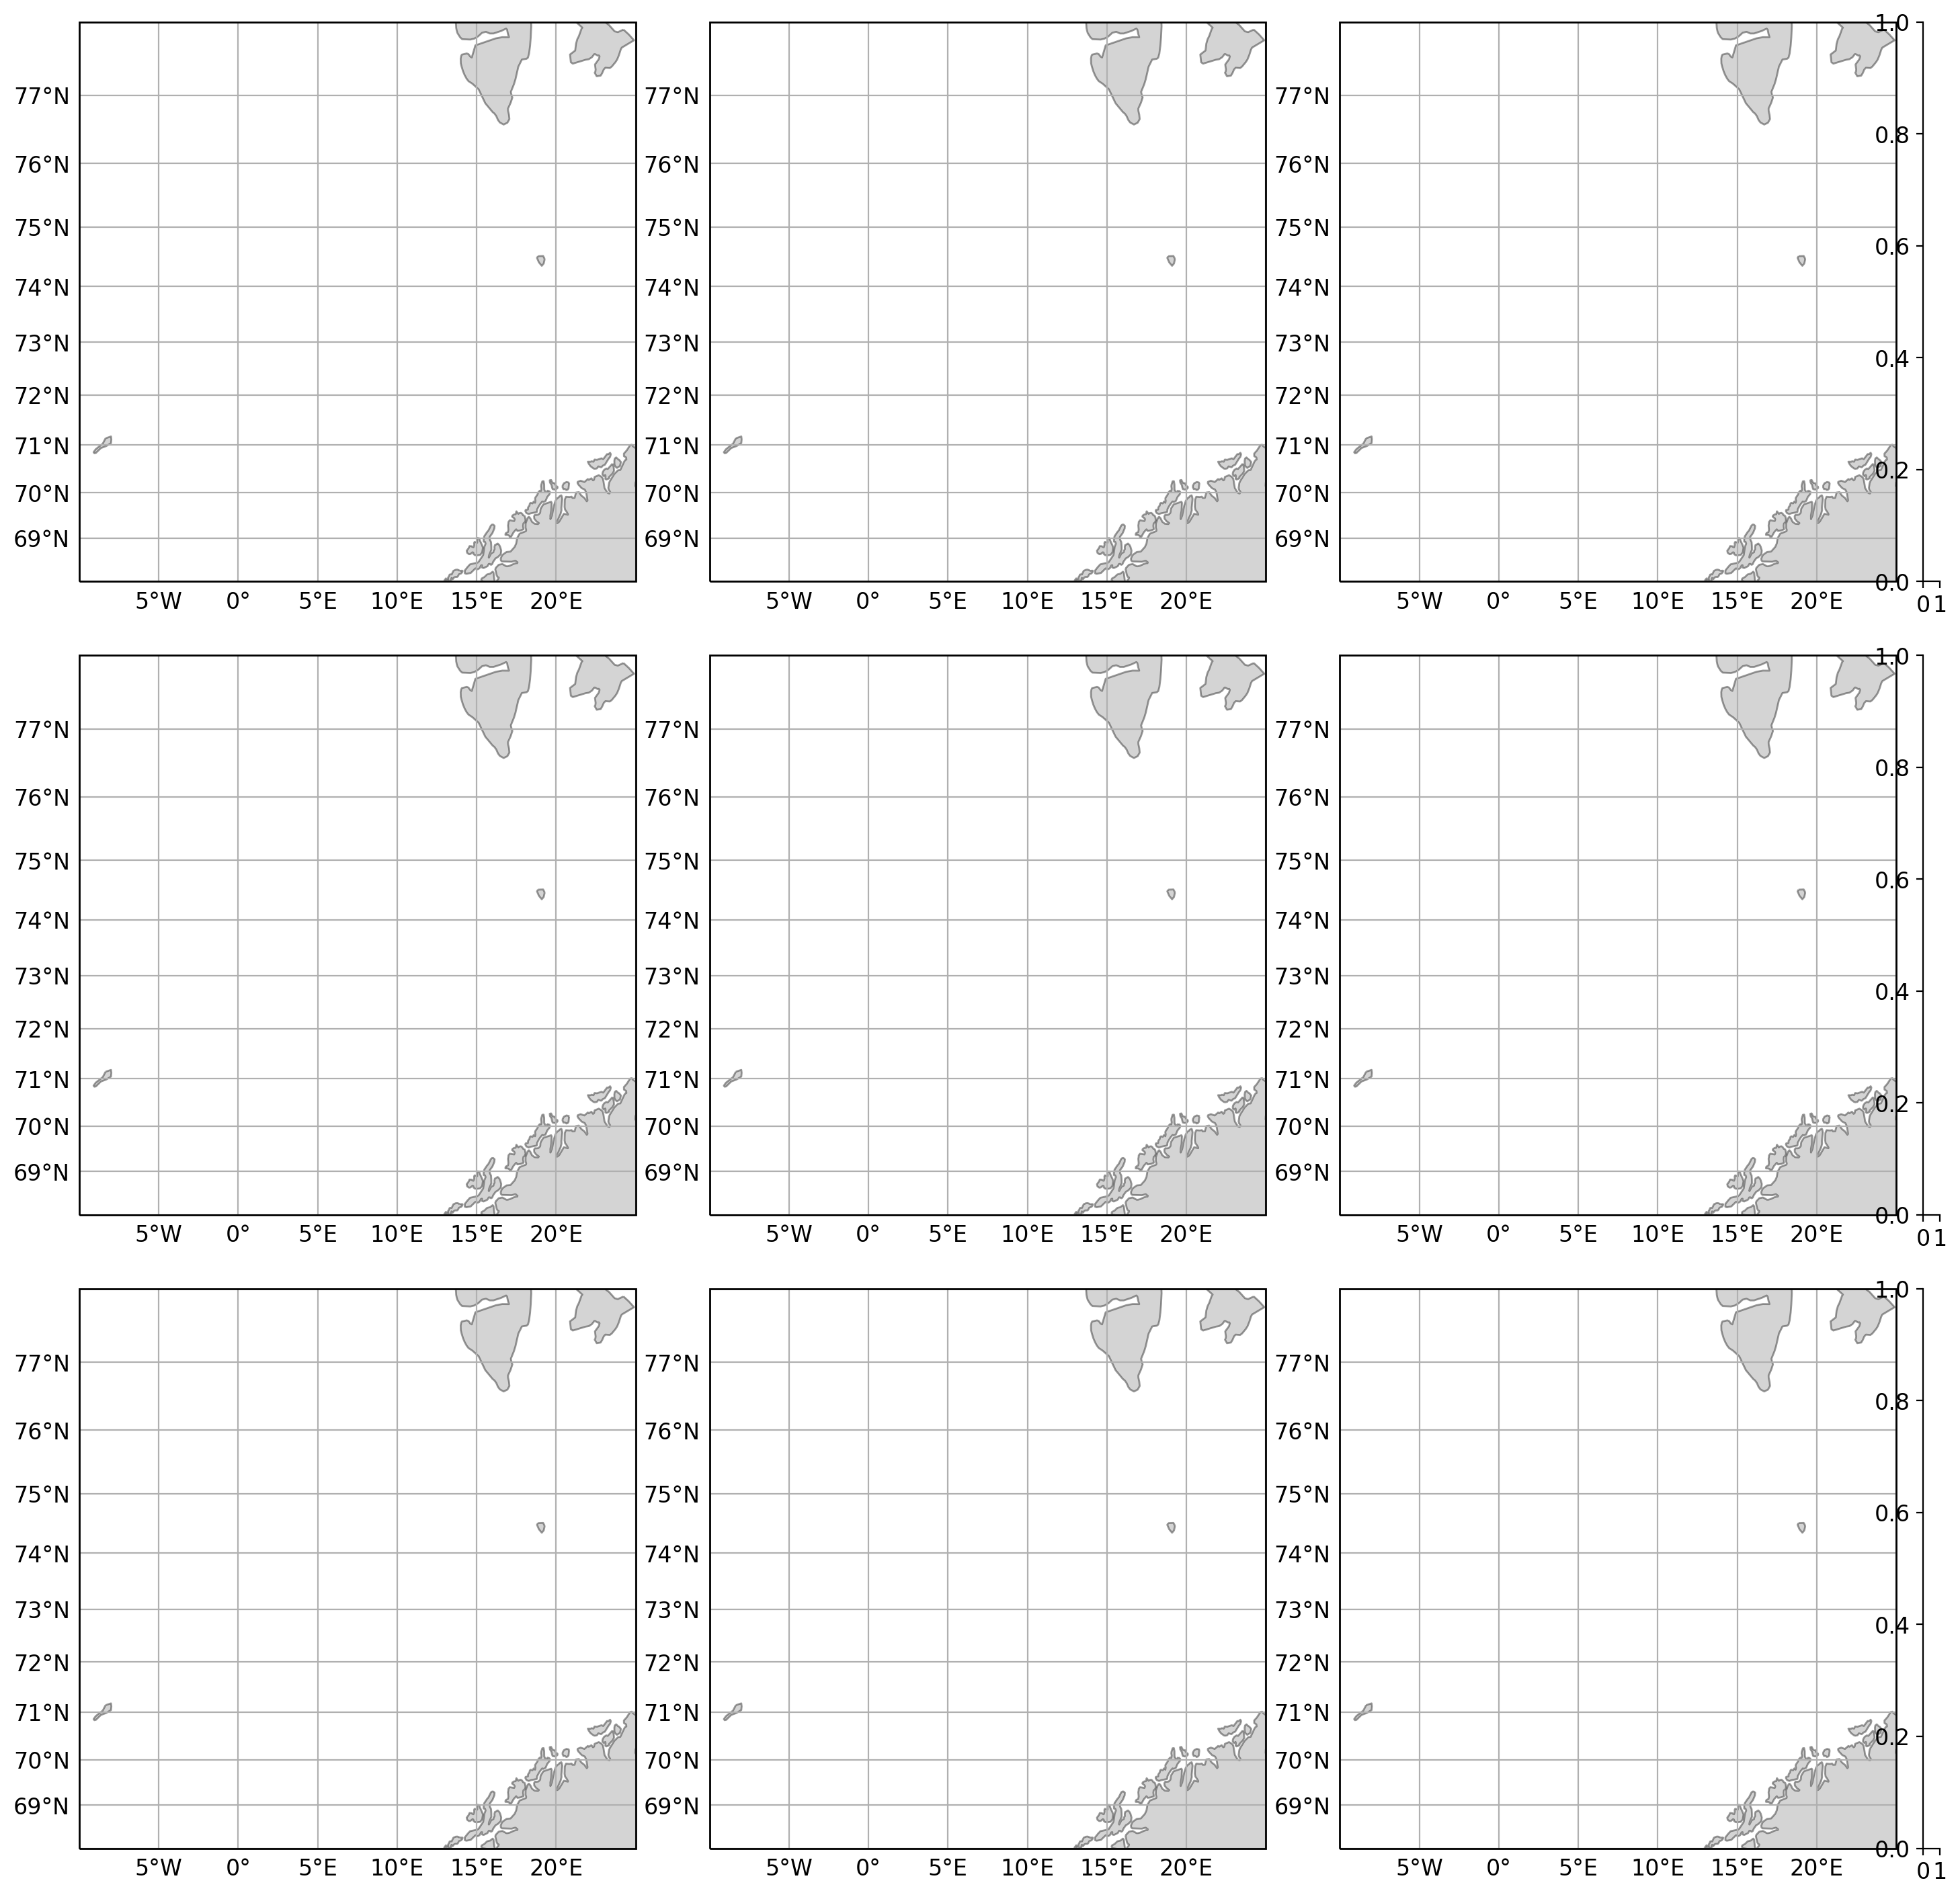

In [28]:
ncol = len(datasets) + 1  # plus ASCAT
nrow = 2 + 1  # plus AVHHR

iletters = iter(string.ascii_lowercase)

fig = plt.figure(figsize=(ncol * 6, nrow * 6))
axgr = merc_map_grid(fig, (nrow, ncol), **MERC_KW, **AXGR_KW)


# Cloud picture from AVHRR
ax.set_title("AVHRR", loc="center", fontsize="medium")
ax = axgr.axes_row[0][0]
ax.imshow(avhrr_im, extent=avhrr_extent, transform=avhrr_crs, **imshow_kw)
# PL track
ax.plot(the_track.lon, the_track.lat, markevery=slice(1, -2), marker=".", **line_kw)
ax.plot(the_track.lon.values[0], the_track.lat.values[0], marker="o", **line_kw)
ax.plot(the_track.lon.values[-1], the_track.lat.values[-1], marker="o", mfc="w", **line_kw)

# Vorticity and sea-level pressure
# ASCAT data in the first column
ax = axgr.axes_row[1][0]
ax.set_title("ASCAT", loc="center", fontsize="medium")
(ascat_ds_regr.vo * vo_scale).plot.pcolormesh(ax=ax, **trans, **vo_kw)

for ax, dataset in zip(axgr.axes_row[1][1:], datasets):
    vort = (dset_dict[dataset].vo.sel(time=accacia_pl_datetime, level=950) * vo_scale)[::-1, :]
    slp = (dset_dict[dataset].msl.sel(time=accacia_pl_datetime) * 1e-2)[::-1, :]
    h0 = vort.plot.pcolormesh(ax=ax, **trans, **vo_kw)

    c = slp.plot.contour(ax=ax, **trans, **slp_kw)
    ax.clabel(c, fmt="%4.0f", colors=slp_kw["colors"], fontsize="small")
    ax.set_title(aliases[dataset], loc="center", fontsize="medium")

# Wind speed
# ASCAT data in the first column
ax = axgr.axes_row[2][0]
ax.set_title("ASCAT", loc="center", fontsize="medium")
ascat_ds_regr.wspd.plot.contourf(ax=ax, **trans, **wspd_kw)
ystride, xstride = strides["ascat"]
ax.quiver(
    ascat_ds_regr.u.longitude.values[::xstride],
    ascat_ds_regr.u.latitude.values[::ystride],
    ascat_ds_regr.u.where(ascat_ds_regr.wspd>1).values[::ystride, ::xstride],
    ascat_ds_regr.v.where(ascat_ds_regr.wspd>1).values[::ystride, ::xstride],
    **trans,
    **quiver_kw,
)

for ax, dataset in zip(axgr.axes_row[2][1:], datasets):
    u = dset_dict[dataset].u.sel(time=accacia_pl_datetime, level=1000)[::-1, :]
    v = dset_dict[dataset].v.sel(time=accacia_pl_datetime, level=1000)[::-1, :]
    wspd = (u ** 2 + v ** 2) ** 0.5
    h1 = wspd.plot.contourf(ax=ax, **trans, **wspd_kw)
    ystride, xstride = strides[dataset]
    ax.quiver(
        u.longitude.values[::xstride],
        u.latitude.values[::ystride],
        u.values[::ystride, ::xstride],
        v.values[::ystride, ::xstride],
        **trans,
        **quiver_kw,
    )
    ax.set_title(aliases[dataset], loc="center", fontsize="medium")

#     if dataset == 'era5':
#         xstride = 1
#         ystride = 1
#     else:
#         xstride = 1
#         ystride = 1
#     p = ax.quiver(u.longitude[::xstride], u.latitude[::ystride],
#                   u.values[::ystride, ::xstride], v.values[::ystride, ::xstride], scale=300, **trans)

cb = fig.colorbar(h0, cax=axgr.cbar_axes[1])
cb.ax.set_title("$10^{-4}$ $s^{-1}$", fontsize="medium")
cb.ax.tick_params(labelsize="large")
cb = fig.colorbar(h1, cax=axgr.cbar_axes[2])
cb.ax.set_title("$m$ $s^{-1}$", fontsize="medium")
cb.ax.tick_params(labelsize="large")

axgr.cbar_axes[0].remove()
for i, ax in enumerate(axgr.axes_all):
    if i in [1, 2]:
        ax.remove()
    else:
        ax.set_title(f"({next(iletters)})", loc="left", fontsize="medium")
        label_map(ax, _toponyms, **trans, **text_kw)
        ax.tick_params(labelsize="xx-small")
plt.close()  # Show the figure in a separate cell

## Show the figure

In [ ]:
fig

And save it.

In [ ]:
fig.savefig(mypaths.plotdir / "ascat_era5_interim_accacia_case_vort_wspd")

## Appendix: extent and grid spacing of ASCAT data

In [ ]:
MERC_KW = {k: v for k, v in LCC_KW.items() if not k in ["clon", "clat"]}
MERC_KW["ticks"] = [5, 1]
MERC_KW["extent"] = [-25, 35, 65, 80]

fig = plt.figure(figsize=(12, 8))
axgr = merc_map_grid(fig, (1, 1), **MERC_KW)

ax = axgr.axes_all[0]
# ax.set_global()

ax.scatter(ascat_ds.lon, ascat_ds.lat, **trans)
ax.scatter(ascat_subset.lon.values, ascat_subset.lat.values, c="C1", **trans)
ax.scatter(ascat_ds.lon.values[cond.values], ascat_ds.lat.values[cond.values], c="C3", **trans)
# ax.scatter(ascat_lons[:, :gap_ind+1], ascat_lats[:, :gap_ind+1], **trans)

ax.add_patch(
    Rectangle(
        (zoom_box[0], zoom_box[2]),
        zoom_box[1] - zoom_box[0],
        zoom_box[3] - zoom_box[2],
        linewidth=1,
        edgecolor="C2",
        facecolor="none",
        **trans
    )
);

#### Test that grid spacing is indeed ~12.5 km

In [ ]:
a = ascat_subset.wind_speed

In [ ]:
from octant.utils import great_circle

In [ ]:
# from itertools import product
# l = list(product((-1, 0, 1), repeat=2))
# l.remove((0, 0))

l = [(-1, 0), (0, -1), (0, 1), (1, 0)]

In [ ]:
ii, jj = 100, 30
for i, j in l:
    gc = (
        great_circle(
            np.float64(a[ii, jj].lon),
            np.float64(a[ii + j, jj + i].lon),
            np.float64(a[ii, jj].lat),
            np.float64(a[ii + j, jj + i].lat),
        )
        / 1e3
    )
    print(i, j, gc)